# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import numpy as np
import torch
from dataset import TextDataset
from model import LanguageModel

In [51]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [5]:
len(train_set) + len(valid_set)

120759

In [ ]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [6]:
model = LanguageModel(train_set)

In [7]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

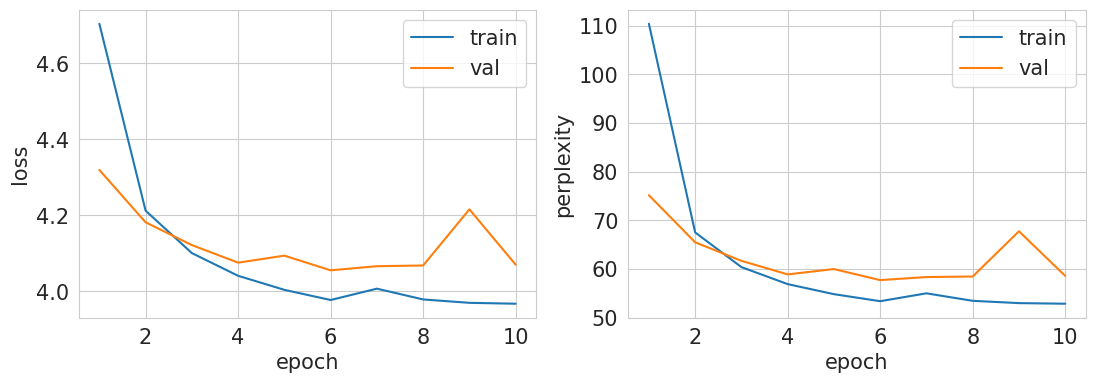

Generation examples:
судя в россии так синпператора, как жирная под ними же график заруду в квартиру.
надо бросать все делам?
если женщина приняга от спала нога. вот теперь беса громко криминальной грузию перенесли сумма маакуру.
у петрона мы гольк лифтк со мной новая бренился атомно. но мне посмотреть о, чтобы вы выхова и продать!- а мама говорил, общество из подравили в стенке, получится логике.
приезжает, когда открываешь электрический гордость, мастер рассказал представитель, ну, давай тогда заходили праву, чаще всего звуки, называются провести шпагам. взяла ее нужен, доктор, у меня железносов рядом...


In [ ]:
import torch.optim as optim
from train import train
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_set)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = None

train(model, optimizer, scheduler, train_loader, valid_loader, num_epochs=10)

In [ ]:
torch.save(model.state_dict(), 'mod_rnn.pth')

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

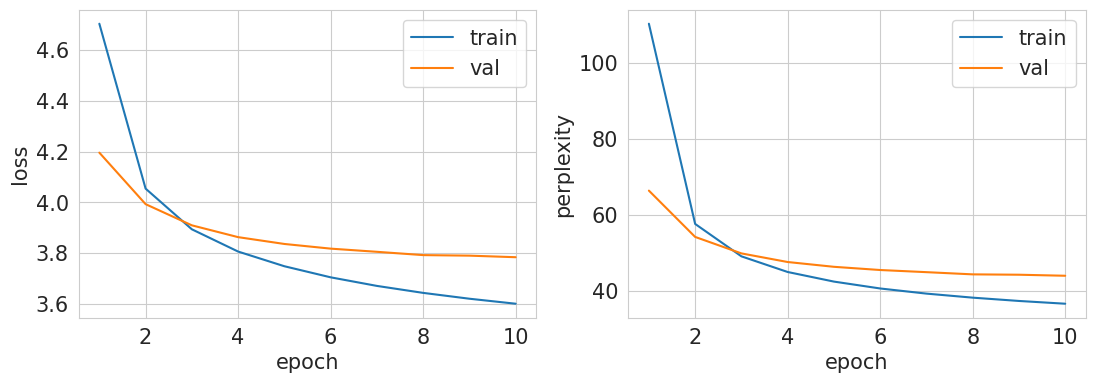

Generation examples:
у календаря подосажника были одни ноги и голова, в заяверные, получило конфеты долго.
парень- девушку по зубов кричит- мама! ты думаешь женщина за тайна?- это на никита!
жена говорит врачу- сынок, уже месяц забываете!- дорогая, а потому что у тебя такой жксток?- нет, очень бороться!
еврейская, пьяным официанту южной жизни в тот кто самый лучший со смехак запаха в какой-то старическим.
- доктор, у вас есть возможность со временных пьяных?- чтобы мне его заставить напиваться.- что вы, вкусной денег, спокойно все время болтали...


In [ ]:
from torch import nn
import torch.optim as optim

model = LanguageModel(train_set, rnn_type=nn.LSTM)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = None

train(model, optimizer, scheduler, train_loader, valid_loader, num_epochs=10)

In [ ]:
torch.save(model.state_dict(), 'mod_lstm.pth')

```
RNN:
loss минимум 4.0
perplexity минимум 50

LSTM:
loss минимум 3.6
perplexity минимум 40

LSTM обучался более плавно, и в целом оказался лучше.

Вот анкедот прям хорошо получился:
парень- девушку по зубов кричит- мама! ты думаешь женщина за тайна?- это на никита!

Можно дальше не делать даже

```

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
# метаирония! она

temps = [0.3, 0.7, 1.0, 1.5, 2.0]
prefixes = ["", "мужик приходит в аптеку", "а баба ему и говорит", "как-то раз штирлиц"]

for prefix in prefixes:
    print(f"\n __ Prefix: '{prefix}' __")
    for temp in temps:
        print(f"\n[temperature = {temp}]")
        print(model.inference(prefix=prefix, temp=temp))


 __ Prefix: '' __

[temperature = 0.3]
жена говорит мужу- дорогой, я хочу спать, а ты знаешь, что ты меня любишь?- да, но у меня нет ни одного непонятной.

[temperature = 0.7]
жена мужу- любимый, это ты сам сдохла, а ко мне с ребятками.- а меня - это у вас нет!

[temperature = 1.0]
расстреляли новый шашлычный новогоднюю ошибку- что делать, познакомлюсь на балконе по русгла наложения?- нет, я думаю в прошлом году.

[temperature = 1.5]
мужик горьет радичи дев телевизохи и кризиса получам. купи много лет бутылостлигоним к враг, что официантлю?! не обеле дерева. старик посовет гильшому в курсу оказалась сша.

[temperature = 2.0]
голод украины начало приъ следу засошу равно строрет женщину знакомству красклюгать пятозо.- что?!- ко телефон за какой0 моей экспеви водуа?! звонит михшей слышали глаза похоло ничего должно лично...- добрый штирлиц! тебе спешлись так марем музы пинка? тут ужарен зво трес и болей тошны, взярожесть быстро зарадо пор.- по мизе я так городар праике нужно перешеродрог

```
Мне больше нравятся те, где температура ниже.
Предельно коротко и ясно, как со шляпой: мужик приходит в аптеку, а там двое.
Где выше - выходит совсем хаос.
```

## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [9]:
train_set_bpe8k = TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="bpe_8000",
    vocab_size=8000,
    model_type="bpe"
)


valid_set_bpe8k = TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix="bpe_8000",
    vocab_size=8000,
    model_type="bpe"
)

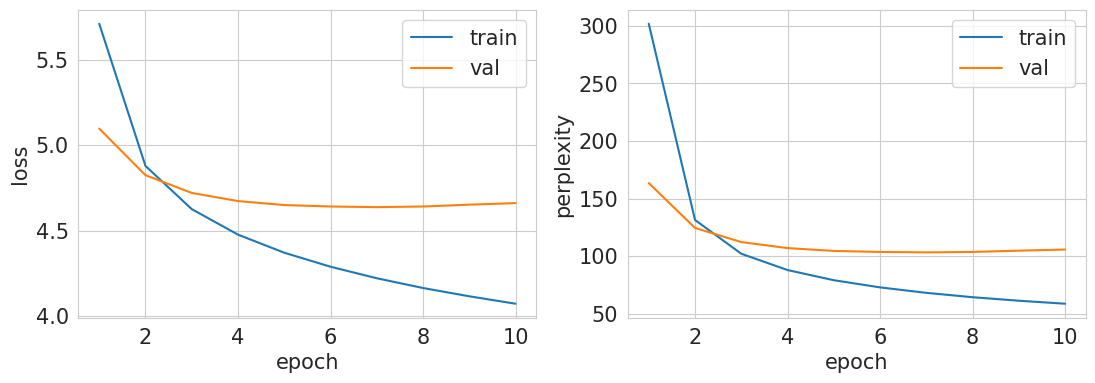

Generation examples:
муж? ты пакал за с уверенностью, протягивает мне подружка, зачинуться мимо и включая следующий диалог, но шаурмой.
люди стали как поздравить мордой и ругайте таракана и на мерках хвасту. если-то в одной школе, воображаемые вы еще как дома стало легче. что ж, опять мерседес еще не стала.
в украине сказано, что коты вступило умение в россии, если мы почти всю приспины будут в дрова, люди должны говорить, что будет лучше всего их удаленных.
у кредитной всего одна женщина тоже отрегули выращивают мужика. будто я пришел ближе к с серьезную жертву, а на экране выходить...
столько не о чем, если экономике, керлингмента и они будут летать на автомобильный бабки.


In [ ]:
model = LanguageModel(train_set_bpe8k, rnn_type=nn.LSTM)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader_bpe8k = DataLoader(train_set_bpe8k, batch_size=32, shuffle=True)
valid_loader_bpe8k = DataLoader(valid_set_bpe8k, batch_size=32, shuffle=False)

train(model, optimizer, scheduler, train_loader_bpe8k, valid_loader_bpe8k, num_epochs=10)

```
Трейн с валидацией стали расходиться сильнее: чем больше запас слов - тем больше вариантов, а угадать из 2к слов проще, чем из 8.
Сравнивать perplexity и даже loss между такими моделями некорректно.
Результаты визуально стали разнообразнее, хотя все еще бестолковые.
BPE по визуальной оценке, кажется, получше схватывает смысл.
```

In [ ]:
torch.save(model.state_dict(), 'mod_lstm_8k.pth')

In [10]:
train_set_uni = TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="unigram_2000",
    vocab_size=2000,
    model_type="unigram"
)

valid_set_uni = TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix="unigram_2000",
    vocab_size=2000,
    model_type="unigram"
)

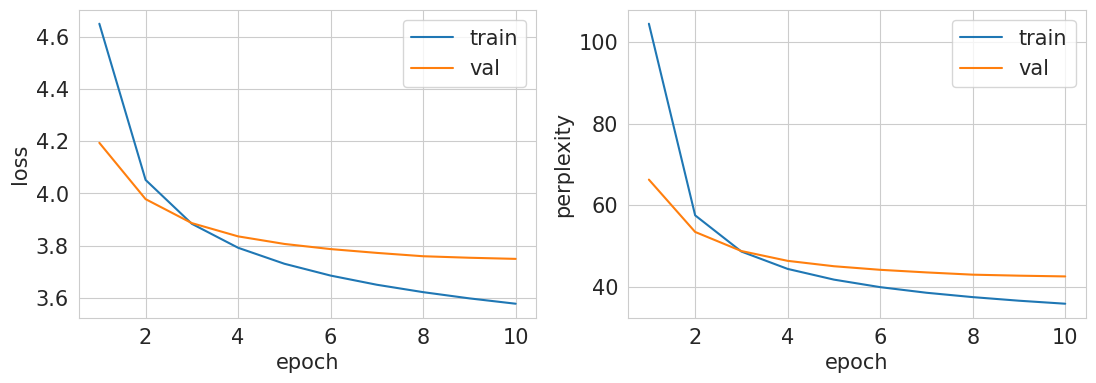

Generation examples:
штирлиц пора дружных дней, задумал и спрашивает- папа, вы в падечу было стоял на своем.- а руки вскочит, пожалуйста?- подруга, мы развеемись?
- привет есть свежие кокаинизма?- не знаю точно задол.
- вынужден единственный врач в нашей семейности в одеске кругом артями, деретесь руками железо? проводаут пожарную дистанцию и богу абрамовичу покуток искусственного норвеймы.
у нас в сторожевую отдела в туалете, фотографике над дверью своей стаю конца!, например, кошка - на удаленках из-за скачок - наоборот.
играл собаку-хозяин, ухит рабинович. звонок в дверь. подходит с решисткой- я уж встретил.- почему моя 25?- было имя.- вот ты чего, а действительно, хорошо, можно, ведь мы вообще говорит наш спросим новый штучки добрые могилу деревь нырлы марковара. кто российский курил и пьет. я его узнал.- я сегодня плохо доступная.


In [15]:
model = LanguageModel(train_set_uni, rnn_type=nn.LSTM)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loader_uni = DataLoader(train_set_uni, batch_size=32, shuffle=True)
valid_loader_uni = DataLoader(valid_set_uni, batch_size=32, shuffle=False)

train(model, optimizer, scheduler, train_loader_uni, valid_loader_uni, num_epochs=10)

In [16]:
torch.save(model.state_dict(), 'mod_lstm_uni.pth')

## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

```
Дальше делаю параллельно с заданием 7: в порядке генерация, оценка + график
```

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# №1 для LSTM unigram_2000

generated_uni = [model.inference("", temp=1.0) for _ in range(len(valid_set))]
decoded_valid = [valid_set.sp_model.decode(indices.tolist()) for indices, _ in valid_set]

corpus = decoded_valid + generated_uni
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(corpus)

In [43]:
corpus[-18]

'после сильной экономии только для хохотоя на лбу. как, русский хвалится с бабами. да положил в бога завдивет любой рыбой и яд верти по интеллектом. идем.'

In [17]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

valid_vectors = X_svd[:len(valid_set)]
gen_vectors = X_svd[len(valid_set):]

similarities = cosine_similarity(gen_vectors, valid_vectors)
lsa_score = similarities.max(axis=1).mean()

print(f"LSA: {lsa_score:.4f}")

LSA: 0.7108


In [46]:
# №2 для LSTM bpe_8000

model_bpe8k = LanguageModel(train_set_bpe8k, rnn_type=nn.LSTM)
model_bpe8k.load_state_dict(torch.load("mod_lstm_8k.pth", map_location=device))
model_bpe8k.to(device)
model_bpe8k.eval()

generated_bpe8k = [model_bpe8k.inference("", temp=1.0) for _ in range(len(valid_set_bpe8k))]

In [49]:
decoded_valid_bpe8k = [
    valid_set_bpe8k.sp_model.decode(indices.tolist())
    for indices, _ in valid_set_bpe8k
]

corpus = decoded_valid_bpe8k + generated_bpe8k
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

valid_vectors = X_svd[:len(decoded_valid_bpe8k)]
gen_vectors = X_svd[len(decoded_valid_bpe8k):]

similarities = cosine_similarity(gen_vectors, valid_vectors)
lsa_score = similarities.max(axis=1).mean()

print(f"LSA BPE-8k: {lsa_score:.4f}")

LSA BPE-8k: 0.7275


In [52]:
# №3 для LSTM (без параметров)

model_lstm = LanguageModel(train_set, rnn_type=nn.LSTM)
model_lstm.load_state_dict(torch.load("mod_lstm.pth", map_location=device))
model_lstm.to(device)
model_lstm.eval()

generated_lstm = [model_lstm.inference("", temp=1.0) for _ in range(len(valid_set))]

In [53]:
decoded_valid_lstm = [
    valid_set.sp_model.decode(indices.tolist())
    for indices, _ in valid_set
]

corpus = decoded_valid_lstm + generated_lstm
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

valid_vectors = X_svd[:len(decoded_valid_lstm)]
gen_vectors = X_svd[len(decoded_valid_lstm):]

similarities = cosine_similarity(gen_vectors, valid_vectors)
lsa_score = similarities.max(axis=1).mean()

print(f"LSA LSTM: {lsa_score:.4f}")

LSA BPE-8k: 0.7244


In [56]:
# №4 для RNN (без параметров)

model_rnn = LanguageModel(train_set, rnn_type=nn.RNN)
model_rnn.load_state_dict(torch.load("mod_rnn.pth", map_location=device))
model_rnn.to(device)
model_rnn.eval()

generated_rnn = [model_rnn.inference("", temp=1.0) for _ in range(len(valid_set))]

In [57]:
decoded_valid_rnn = [
    valid_set.sp_model.decode(indices.tolist())
    for indices, _ in valid_set
]

corpus = decoded_valid_rnn + generated_rnn
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

valid_vectors = X_svd[:len(decoded_valid_rnn)]
gen_vectors = X_svd[len(decoded_valid_rnn):]

similarities = cosine_similarity(gen_vectors, valid_vectors)
lsa_score = similarities.max(axis=1).mean()

print(f"LSA RNN: {lsa_score:.4f}")

LSA RNN: 0.7318


Смотрим близость текстов после снижения размерности - это интересно.
Только в моем случае получилось довольно неплохое качество по метрике, хотя грамматически тексты вяжутся все еще плохо.

* **Плюсы**: метрика должна учитывать смысловую близость и семантику, не только н-граммы, удобна для сравнения моделей с разными параметрами и типами.

* **Главный минус**: не учитывает грамматику и синтаксис, переоценивает бессмысленные тексты.


## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [18]:
# №1 для LSTM unigram_2000

from sklearn.manifold import TSNE

all_vectors = np.vstack([valid_vectors, gen_vectors])
labels = ['valid'] * len(valid_vectors) + ['generated'] * len(gen_vectors)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(all_vectors)

In [27]:
X_tsne[:, 0]

array([ 39.151768 ,  20.605322 ,  -4.4956627, ..., -36.42935  ,
       -18.719452 ,  65.44234  ], dtype=float32)

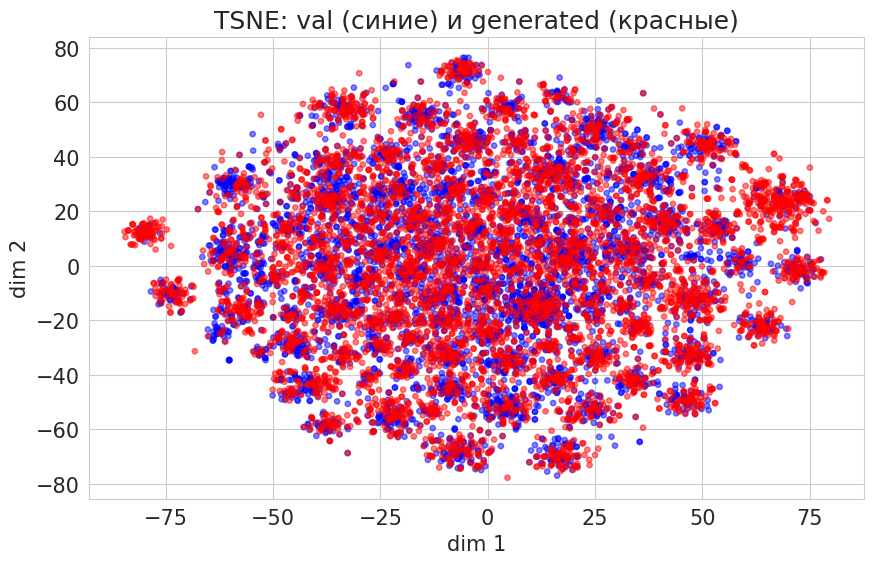

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = ['blue' if label == 'valid' else 'red' for label in labels]

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5, s=15)
plt.title("TSNE: val (синие) и generated (красные)")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.grid(True)
plt.show()

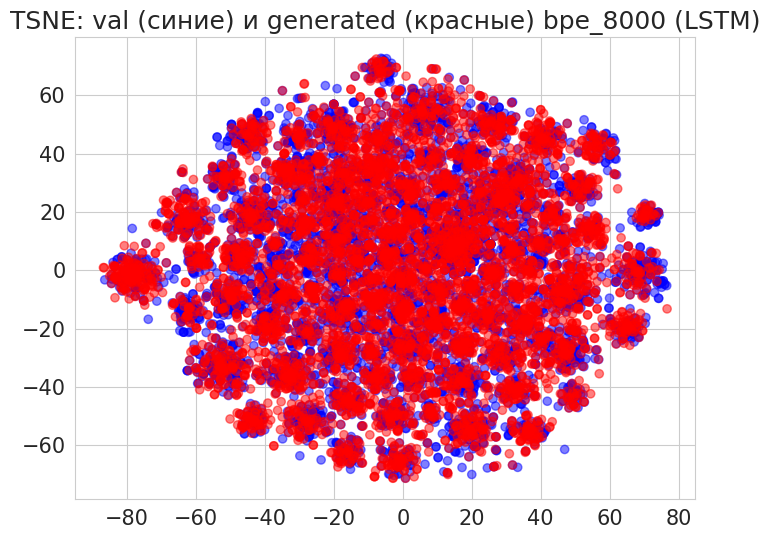

In [50]:
# №2 для LSTM bpe_8000

X_all = np.vstack([valid_vectors, gen_vectors])
labels = ['valid'] * len(valid_vectors) + ['generated'] * len(gen_vectors)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_all)

colors = ['blue' if label == 'valid' else 'red' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5)
plt.title("TSNE: val (синие) и generated (красные) bpe_8000 (LSTM)")
plt.show()

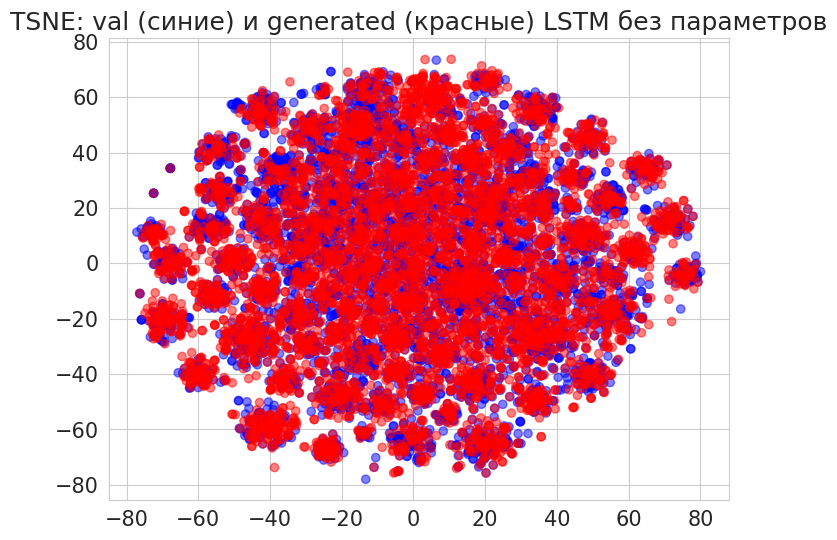

In [55]:
# №3 для LSTM (без параметров)

X_all = np.vstack([valid_vectors, gen_vectors])
labels = ['valid'] * len(valid_vectors) + ['generated'] * len(gen_vectors)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_all)

colors = ['blue' if label == 'valid' else 'red' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5)
plt.title("TSNE: val (синие) и generated (красные) LSTM без параметров")
plt.show()

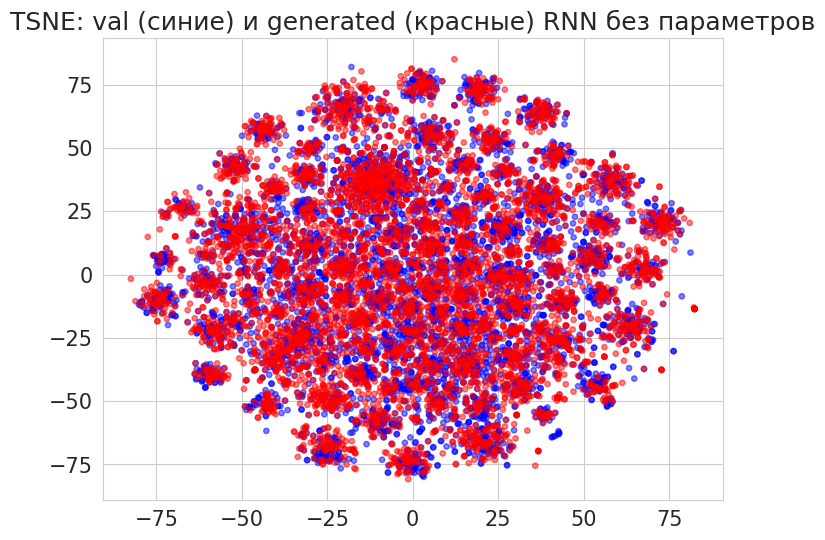

In [58]:
# №4 для RNN (без параметров)

X_all = np.vstack([valid_vectors, gen_vectors])
labels = ['valid'] * len(valid_vectors) + ['generated'] * len(gen_vectors)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_all)

colors = ['blue' if label == 'valid' else 'red' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5, s=15)
plt.title("TSNE: val (синие) и generated (красные) RNN без параметров")
plt.show()

Вышло в целом похоже по соответствию точек, но границы значений разные.

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [60]:
!pip install transformers accelerate -q

In [61]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")
gpt_model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2").to(device)
gpt_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/551M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [63]:
def calculate_perplexity(texts, model, tokenizer, device, max_length=512):
    ppl_scores = []

    for text in tqdm(texts, desc="Оценка PPL"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        input_ids = inputs["input_ids"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            ppl = torch.exp(loss).item()
            ppl_scores.append(ppl)

    return np.mean(ppl_scores)

In [64]:
ppl_bpe2k = calculate_perplexity(generated_lstm, gpt_model, tokenizer, device)
ppl_bpe8k = calculate_perplexity(generated_bpe8k, gpt_model, tokenizer, device)
ppl_uni = calculate_perplexity(generated_uni, gpt_model, tokenizer, device)

print(f"Perplexity BPE-2k:  {ppl_bpe2k:.2f}")
print(f"Perplexity BPE-8k:  {ppl_bpe8k:.2f}")
print(f"Perplexity Unigram: {ppl_uni:.2f}")

Оценка PPL: 100%|██████████| 6037/6037 [01:10<00:00, 86.01it/s]

Perplexity BPE-2k:  2694.06
Perplexity BPE-8k:  1852.17
Perplexity Unigram: 2608.08


```
Хорошей модели непонятен этот наш язык, как и следовало ожидать.
Но если сравнивать модели между собой: получше с точки зрения гпт оказалась модель с большим словарем (bpe 8000).
```

In [75]:
temps = [0.3, 0.7, 1.0, 0.3, 0.7, 1.0]
prefixes = [ "искусственный интеллект", "доктор, а что такое ", "вовочка "]

for prefix in prefixes:
    print(f"\n __ Prefix: '{prefix}' __")
    for temp in temps:
        print(model_bpe8k.inference(prefix=prefix, temp=temp))


 __ Prefix: 'искусственный интеллект' __
искусственный интеллект, который придумал свои слова, чтобы не платить налоги.
искусственный интеллект думает, что он из-за карантина вы неразливались люди, которые они не сводятся.
искусственный интеллект - ни в то, что в жизни должен быть земногого людей только в одном случае платной панике?!
искусственный интеллект - это когда человек начинает плакать, а не уступает с собой.
искусственный интеллект, а я - на работу.
искусственный интеллект, короткая администратора на руководство выходом подальше в своем бассейн...

 __ Prefix: 'доктор, а что такое ' __
доктор, а что такое?- да, я на тебя не знаю, но я же не понял, но я не могу, а в чем дело?- да, но я же не понял...
доктор, а что такое, что забудь фразу в больнице?сходит официант- слушай, а когда вы видите в чем секрет?- за две полоски, по 2 ⁇ , сэр!
доктор, а что такое?- девушки, вы доживешь.- как? кладите один как девочка.
доктор, а что такое, что вы хотите, чтобы я не могу найти черную ко

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Мой топ:
* искусственный интеллект - это когда в россии есть еще одна проблема
* искусственный интеллект, который придумал свои слова, чтобы не платить налоги.
* дружба - это слишком много активов!
* счастье - это когда с ней и в душе, и на похороны будут греть...
